In [ ]:
import pymc as pm
import numpy as np
import matplotlib.pyplot as plt
import arviz as az
import pandas as pd

  error: subprocess-exited-with-error
  
  × installing build dependencies for pytensor did not run successfully.
  │ exit code: 2
  ╰─> [123 lines of output]
        Using cached setuptools-80.9.0-py3-none-any.whl.metadata (6.6 kB)
        Using cached cython-3.2.2-cp314-cp314-macosx_11_0_arm64.whl.metadata (5.0 kB)
        Using cached numpy-1.25.2.tar.gz (10.8 MB)
        Installing build dependencies: started
        Installing build dependencies: finished with status 'done'
        Getting requirements to build wheel: started
        Getting requirements to build wheel: finished with status 'done'
      ERROR: Exception:
      Traceback (most recent call last):
        File "/Users/liamcarlin/Library/CloudStorage/OneDrive-OlinCollegeofEngineering/Documents/ProbMod/changepoint/.venv/lib/python3.14/site-packages/pip/_internal/cli/base_command.py", line 107, in _run_wrapper
          status = _inner_run()
        File "/Users/liamcarlin/Library/CloudStorage/OneDrive-OlinCollegeofEngi

ModuleNotFoundError: No module named 'pymc'

Generating the product data:
we can track the number of sales per day. Dealing with count data. use a poisson distribution to model sales per day. with lambda being the average sales per day.
To get over the independence between days, we can use conditional independence. we can introduce a changepoint, after a certain day the average rate (lambda) can be higher or lower. 

one changepoints, two lambda values.
1st changepoint - viral point.
(maybe 2nd changepoint - the crash/fall off.)

We can use a poisson distribution to model sales data (non negative whole numbers)
lambda = rate = mean sales

We can use PYMC mcmc to model
calculating posterior distribution for our Lambda, and tau is hard
we can use MCMC, explore all possibilities using markov chain, samples to predict the shape our posterior distribution

2 Kernels:
kernel for lambda: normal distribution centered at current lambda
kernel for tau: uniform distibution 

initial lambda value is sampled from the prior distribution the exponential. guarantees we pick a valid starting number
initial tau sampled from discrete uniform

posterior = likelihood x prior

we can calculate the prior of each day sale using each distribution (exp and discrete unif). f(x) = ae^-ax and 1/N so prior = prior of lambda * prior of discrete
likelihood (give the rates what the prob of seeing this sale). p(k|lambda,tau). we can calculate the poisson probability of each with the formula (lambda^k*e^-lambda)/k!




In [7]:
def run_model_for_day(day_t, all_sales_data):
    
    observed_data = all_sales_data[:day_t]
    
    with pm.Model() as model:
        
        alpha = 1.0 / (observed_data.mean() + 0.01)
        
        lambda_1 = pm.Exponential("lambda_1", alpha)
        lambda_2 = pm.Exponential("lambda_2", alpha)
        
    
        tau = pm.DiscreteUniform("tau", lower=0, upper=day_t)
        
        
        idx = np.arange(day_t)
        lambda_t = pm.math.switch(idx < tau, lambda_1, lambda_2)
        
        
        observation = pm.Poisson("obs", mu=lambda_t, observed=observed_data)
        
        idata = pm.sample(1000, tune=1000, progressbar=False)
        
    return idata

In [47]:
data = pd.read_csv('sales_data_sample.csv', encoding='latin1')



N = 100 # no. days
days = np.arange(1,N+1)
lambda_1 = 5
lambda_2 = 40
#lambda_3 = 20

cp_1 = 35
#cp_2 = 80
lambda_series = np.zeros(N)
lambda_series[:cp_1] = lambda_1
lambda_series[cp_1:] = lambda_2
#lambda_series[cp_2:] = lambda_3
print(lambda_series)

sales_data = np.random.poisson(lambda_series)

data['ORDERDATE'] = pd.to_datetime(data['ORDERDATE']) 

sales_data_sample = data.groupby(data['ORDERDATE'].dt.date)['QUANTITYORDERED'].sum()
sales_data_sample = sales_data_sample.values
print(sales_data_sample)
#data.head(5)
#data.info()

print(len(sales_data_sample))


[ 5.  5.  5.  5.  5.  5.  5.  5.  5.  5.  5.  5.  5.  5.  5.  5.  5.  5.
  5.  5.  5.  5.  5.  5.  5.  5.  5.  5.  5.  5.  5.  5.  5.  5.  5. 40.
 40. 40. 40. 40. 40. 40. 40. 40. 40. 40. 40. 40. 40. 40. 40. 40. 40. 40.
 40. 40. 40. 40. 40. 40. 40. 40. 40. 40. 40. 40. 40. 40. 40. 40. 40. 40.
 40. 40. 40. 40. 40. 40. 40. 40. 40. 40. 40. 40. 40. 40. 40. 40. 40. 40.
 40. 40. 40. 40. 40. 40. 40. 40. 40. 40.]
[ 151  142   80  541  443  545  675  229  561  212  570   52  217  143
  351  210   27  402   36  442  525  185  545  156  514  617  540  157
  349  317  286  227  607  102  138  266  385  290  577  524   20  563
   76  341  430  367  380  342  116  458   67  251  369  700   68  607
  231  358  391  225  386  670  550  642  586  888  977  377  413  458
 1093  391 1306  329  170  902  447  781  819  242  329 1010  180  355
  615  530  269  577  530  612   90  241  396   43  240  147  289  167
  717  497  241  483  237  502  194  476  338   91  272  105  390   81
  239  280  163  497   46

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [lambda_1, lambda_2]
>Metropolis: [tau]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 17 seconds.
c:\Users\zadeboye\AppData\Local\Programs\Python\Python313\Lib\site-packages\arviz\stats\diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
C:\Users\zadeboye\AppData\Local\Temp\ipykernel_27804\847694834.py:24: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [lambda_1, lambda_2]
>Metropolis: [tau]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 18 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates prob

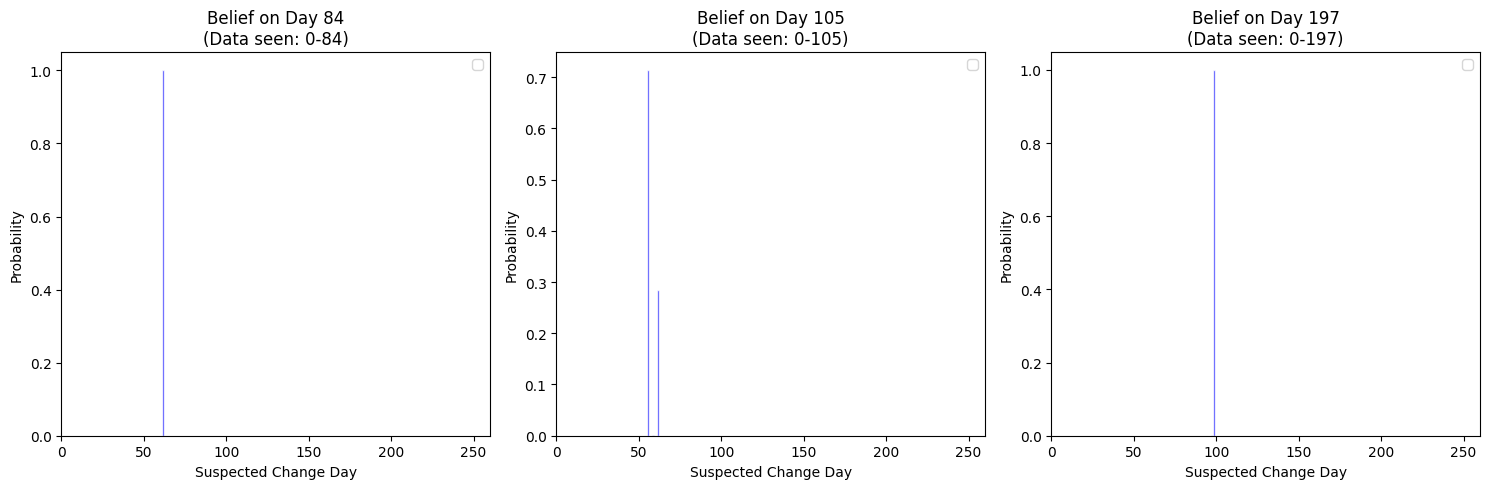

In [ ]:

check_days = [84, 105, 197]

plt.figure(figsize=(15, 5))

for i, day in enumerate(check_days):
    
    result = run_model_for_day(day, sales_data_sample)
    
    
    tau_samples = result.posterior["tau"].values.flatten()
    
    plt.subplot(1, 3, i+1)
    
    # We plot the histogram to show probability density
    plt.hist(tau_samples, bins=range(day), density=True, 
             color='blue', edgecolor='white', alpha=0.8)
    
    
    #plt.axvline(cp_1, color='red', linestyle='--', linewidth=2, label='True Change (Day 35)')
    
    plt.title(f"Belief on Day {day}\n(Data seen: 0-{day})")
    plt.xlabel("Suspected Change Day")
    plt.ylabel("Probability")
    plt.legend()
    plt.xlim(0, len(sales_data_sample) + 5) 

plt.tight_layout()
plt.show()

1306 72
1306 72
1365 190


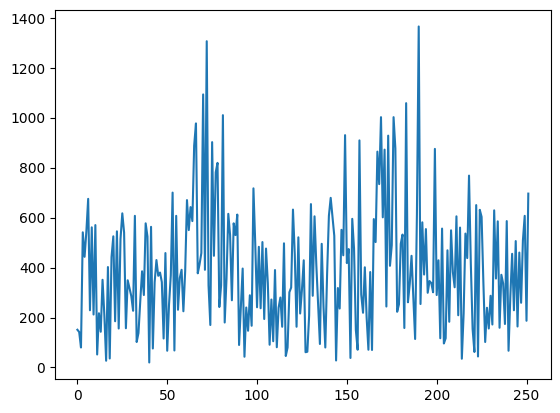

In [57]:
print(np.max(sales_data_sample[0:85]),
np.argmax(sales_data_sample[0:85]))

print(np.max(sales_data_sample[0:105]),
np.argmax(sales_data_sample[0:105]))

print(np.max(sales_data_sample[0:196]),
np.argmax(sales_data_sample[0:196]))


days  = np.arange(252)
plt.plot(days, sales_data_sample)
plt.show()